In [1]:
using AA222
using PyPlot
using Interact
srand(10);

# Polynomial Models

Let's generate some random data according to a noisy function
$$f(x) = x^2 + \epsilon$$
where $\epsilon \sim \mathcal{N}(0, 0.2^2)$.

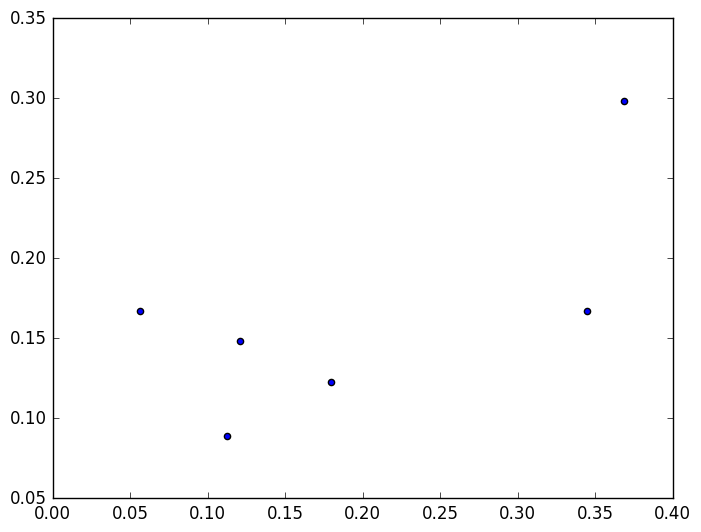

In [2]:
X = rand(6)' # six random input points
Y = X.^2 + 0.2 * rand(size(X))
scatter(X,Y);

Vandermonde matrix:
$$\Phi(x) = \left[\begin{matrix} 1 & x_1 & x_1^2 & \cdots & x_1^m \\ 1 & x_2 & x_2^2 & \cdots & x_2^m \\ & & \vdots \\ 1 & x_n & x_n^2 & \cdots & x_n^m \end{matrix}\right]$$

In [3]:
function vander(X, order)
    Phi = zeros(length(X), order + 1)
    for i = 1:length(X)
        Phi[i,:] = [X[i]^k for k = 0:order]
    end
    return Phi
end

vander (generic function with 1 method)

In [4]:
vander(X,3)

6x4 Array{Float64,2}:
 1.0  0.112582   0.0126748   0.00142696 
 1.0  0.368314   0.135655    0.0499637  
 1.0  0.344454   0.118649    0.040869   
 1.0  0.0566454  0.00320871  0.000181759
 1.0  0.120781   0.0145879   0.00176194 
 1.0  0.179574   0.0322468   0.0057907  

$\hat f(x) = \hat w^\top \Phi(x)$  
$\hat w = \Phi^+(x) y$ (least-squares estimate with $\Phi^+$ as pseudo-inverse)  

In [5]:
function polyfit(X, y, order)
    w = pinv(vander(X, order)) * y'
    return x -> (w' * vander(x, order)')[1]
end    

polyfit (generic function with 1 method)

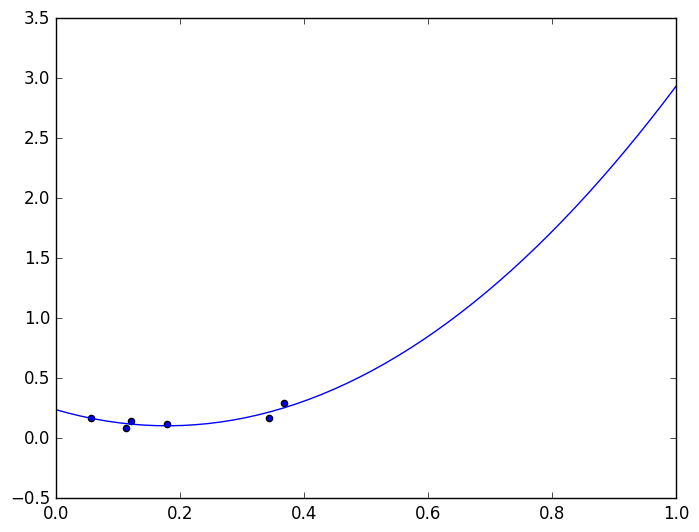

In [6]:
f = polyfit(X, Y, 2) # fit the data
scatter(X,Y)
xdom(0,1)
plot(f);

Interact.Slider{Int64}(Signal{Int64}(5, nactions=0),"order",5,1:9,true)

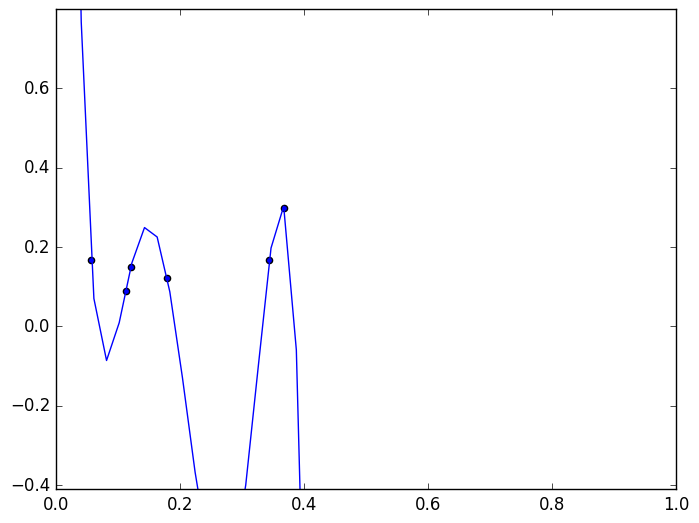

In [7]:
# try fits with different orders
fig = figure()
@manipulate for order = 1:9
    withfig(fig) do
        scatter(X,Y)
        f = polyfit(X,Y,order)
        plot(f)
        xlim(0,1)
        ylim(minimum(Y) - 0.5, maximum(Y) + 0.5)
    end    
end

In [8]:
# calculate the mean squared error (MSE) of f using test points X and target values y
function mse(f, X, y)
    n = size(X,2)
    mean([(f(X[:,i]) - y[i])^2 for i = 1:n])
end

mse (generic function with 1 method)

Interact.Slider{Int64}(Signal{Int64}(5, nactions=0),"order",5,1:9,true)

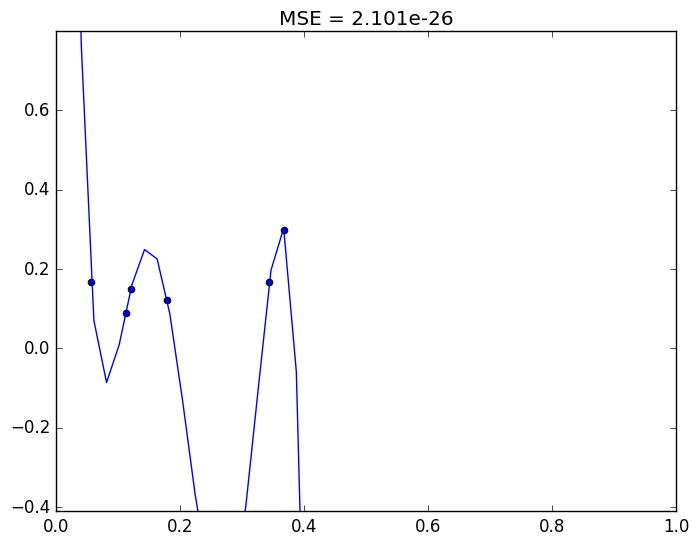

In [9]:
# compute MSE for various points
fig = figure()
@manipulate for order = 1:9
    withfig(fig) do
        scatter(X,Y)
        f = polyfit(X,Y,order)
        plot(f)
        xlim(0,1)
        ylim(minimum(Y) - 0.5, maximum(Y) + 0.5)
        title(@sprintf("MSE = %.3e", mse(f, X, Y)))
    end
end

How to pick the best order (and avoid overfitting)? Separate test set from training set.

# Cross Validation

In [10]:
type CVSet
    trainIndex
    testIndex
end

In [11]:
function cvSetHoldOut(n, holdOutProportion)
    perm = randperm(n)
    numTest = round(UInt, holdOutProportion*n)
    testInd = 1:numTest
    trainInd = (numTest+1):n
    return [CVSet(perm[trainInd], perm[testInd])]
end

cvSetHoldOut (generic function with 1 method)

In [12]:
function cv(X, y, trainFunction, cvSets, lossFunction)
    loss = 0
    for i = 1:length(cvSets)
        cvSet = cvSets[i]
        # train
        Xtrain = X[:,cvSet.trainIndex]
        ytrain = y[cvSet.trainIndex]'
        f = trainFunction(Xtrain, ytrain)
        # test
        Xtest = X[:,cvSet.testIndex]
        ytest = y[cvSet.testIndex]'
        n = size(Xtest,2)
        for j = 1:n
            loss += lossFunction(f(Xtest[:,j]), ytest[j])
        end
    end
    return loss
end

cv (generic function with 1 method)

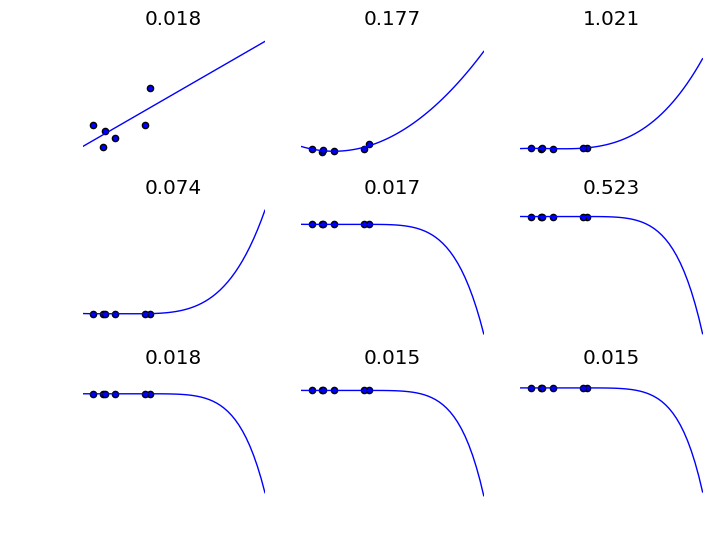

In [13]:
# metric
cvMetric(train) = cv(X, Y, train, cvSetHoldOut(size(X,2), 0.5), sqloss)
sqloss(x,y) = (x - y)^2

order = 9
numrow = 3
numcol = 3
for i = 1:order
    subplot(numrow, numcol, i)
    scatter(X,Y)
    train(x,y) = polyfit(x, y, i)
    f = train(X,Y)
    plot(f)
    axis("off")
#     xlim(0,1)
#     ylim(0,1)
    title(@sprintf("%.3f", cvMetric(train)))
end

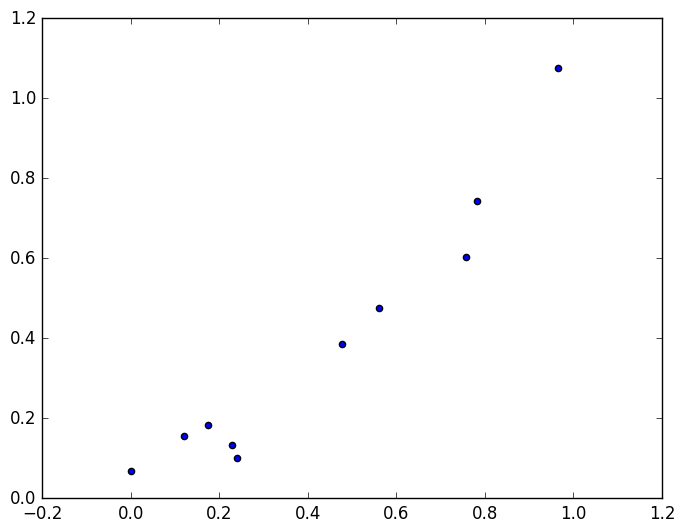

In [14]:
# let's make more samples
X = rand(10)'
Y = X.^2 + 0.2 * rand(size(X))
scatter(X,Y);

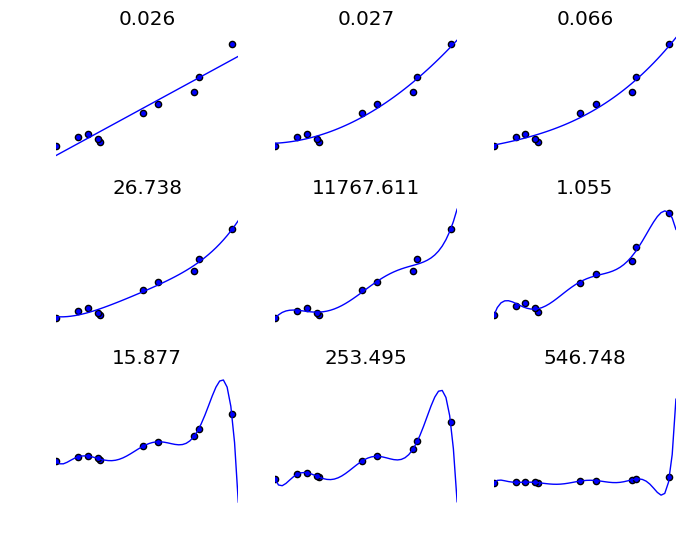

In [15]:
order = 9
numrow = 3
numcol = 3
for i = 1:order
    subplot(numrow, numcol, i)
    scatter(X,Y)
    train(x,y) = polyfit(x, y, i)
    f = train(X,Y)
    plot(f)
    axis("off")
#     xlim(0,1)
#     ylim(0,1)
    title(@sprintf("%.3f", cvMetric(train)))
end

In [16]:
function cvSetKFold(n, k)
    assert(k <= n)
    perm = randperm(n)
    sets = cell(k)
    for i = 1:k
        test = perm[i:k:n];
        train = perm[setdiff(1:n, i:k:n)]
        sets[i] = CVSet(train, test)
    end
    return sets
end

cvSetKFold (generic function with 1 method)

In [17]:
cvSetKFold(10,2)

2-element Array{Any,1}:
 CVSet([8,10,6,5,9],[3,4,1,2,7])
 CVSet([3,4,1,2,7],[8,10,6,5,9])

In [18]:
cvSetJackKnife(n) = cvSetKFold(n,n)
cvSetKFold(10,10)

10-element Array{Any,1}:
 CVSet([4,2,5,10,3,6,8,1,7],[9])
 CVSet([9,2,5,10,3,6,8,1,7],[4])
 CVSet([9,4,5,10,3,6,8,1,7],[2])
 CVSet([9,4,2,10,3,6,8,1,7],[5])
 CVSet([9,4,2,5,3,6,8,1,7],[10])
 CVSet([9,4,2,5,10,6,8,1,7],[3])
 CVSet([9,4,2,5,10,3,8,1,7],[6])
 CVSet([9,4,2,5,10,3,6,1,7],[8])
 CVSet([9,4,2,5,10,3,6,8,7],[1])
 CVSet([9,4,2,5,10,3,6,8,1],[7])

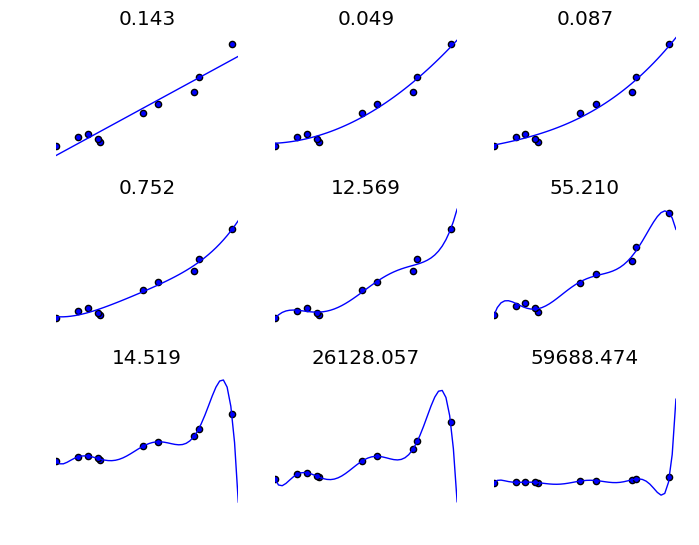

In [19]:
# metric
cvMetric(train) = cv(X, Y, train, cvSetJackKnife(size(X,2)), sqloss)

order = 9
numrow = 3
numcol = 3
for i = 1:order
    subplot(numrow, numcol, i)
    scatter(X,Y)
    train(x,y) = polyfit(x, y, i)
    f = train(X,Y)
    plot(f)
    axis("off")
    title(@sprintf("%.3f", cvMetric(train)))
end

# Radial Basis Functions

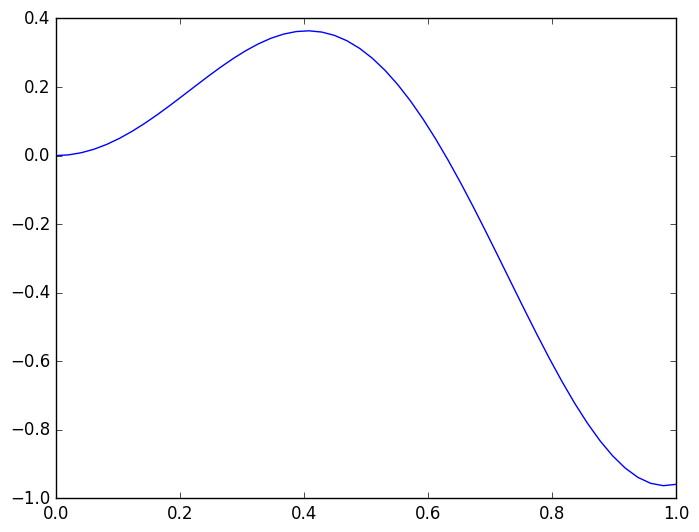

In [20]:
# true function
f = x -> x .* sin(5 .* x)
xdom(0,1)
plot(f);

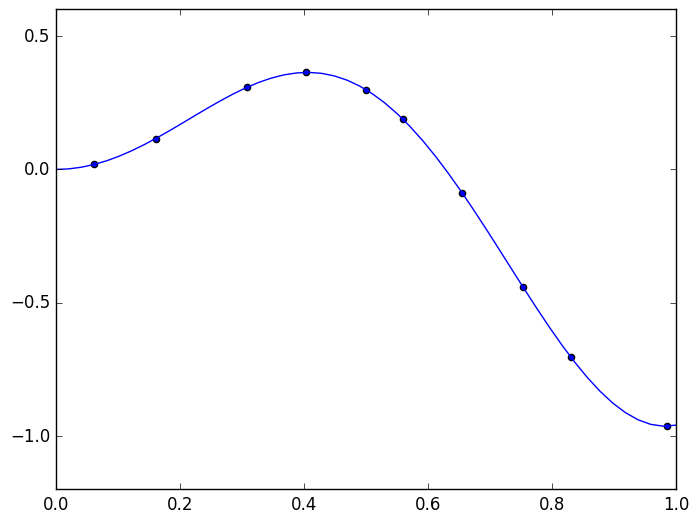

In [21]:
# Let's add some random samples from this function as the training data
X = rand(10)'
Y = f(X)
xdom(0,1)
plot(f)
scatter(X,Y);

Gram matrix $\Psi_{ij} = \psi(||x^{(i)} - x^{(j)}||)$

In [22]:
function gram(X, basisFunction)
    n = size(X,2)
    G = zeros(n,n)
    for i = 1:n
        for j = 1:n
            G[i,j] = basisFunction(norm(X[:,i] - X[:,j]))
        end
    end
    return G
end

gram (generic function with 1 method)

In [23]:
basisFunction = r->exp(-10*r^2)
gram(X, basisFunction)

10x10 Array{Float64,2}:
 1.0          0.787378    0.00111421  …  0.583097    0.0337083  0.0102035
 0.787378     1.0         0.0112339      0.941502    0.160631   0.0652035
 0.00111421   0.0112339   1.0            0.0299343   0.555781   0.804551 
 0.000196979  0.00269828  0.906436       0.00838615  0.311599   0.544423 
 0.337506     0.736305    0.0862497      0.909633    0.528135   0.298807 
 0.164021     0.480916    0.202836    …  0.689209    0.781392   0.530047 
 0.0954229    0.336334    0.314983       0.528688    0.909266   0.690562 
 0.583097     0.941502    0.0299343      1.0         0.293783   0.138185 
 0.0337083    0.160631    0.555781       0.293783    1.0        0.913893 
 0.0102035    0.0652035   0.804551       0.138185    0.913893   1.0      

In [24]:
w = pinv(gram(X, basisFunction))*Y'

10x1 Array{Float64,2}:
  -0.100174
  -8.47987 
  -1.91312 
   0.732627
 -29.1425  
  37.3709  
 -24.2668  
  20.1018  
   2.74347 
   2.37469 

In [25]:
function radialBasisInterpolation(X, y, basisFunction)
    w = pinv(gram(X, basisFunction)) * y'
    return x -> (w'*Float64[basisFunction(norm(x - X[:,i])) for i = 1:size(X,2)])[1]
end

radialBasisInterpolation (generic function with 1 method)

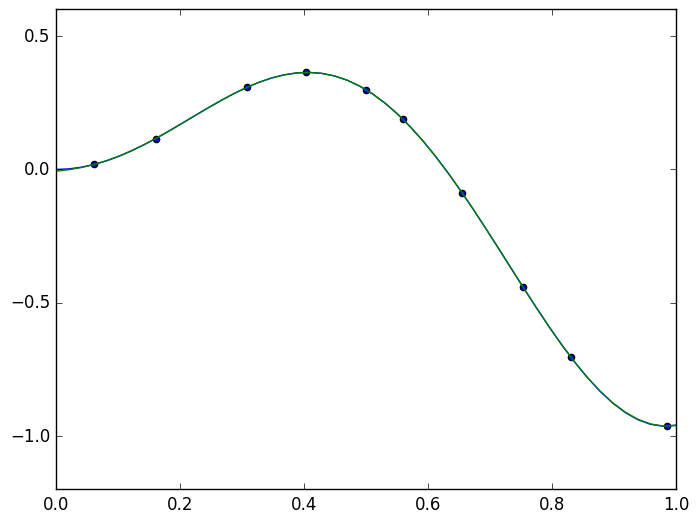

In [26]:
xdom(0,1)
plot(f)
scatter(X,Y)
plot(radialBasisInterpolation(X, Y, basisFunction));

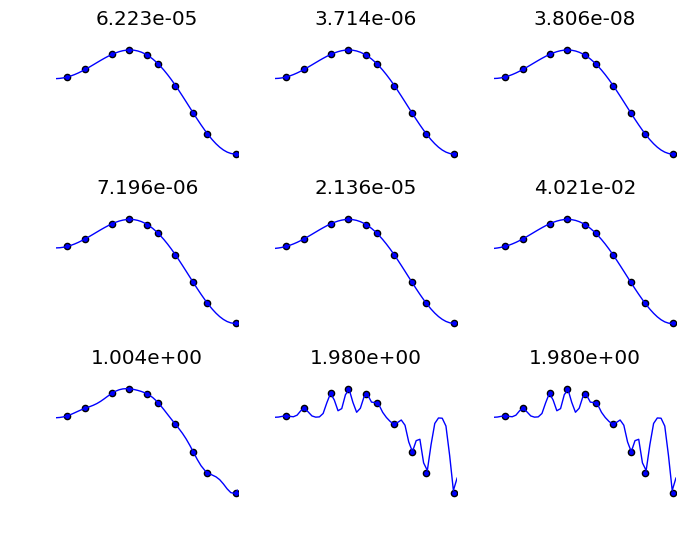

In [27]:
cvMetric(train) = cv(X, Y, train, cvSetJackKnife(size(X,2)), sqloss)
scale = [0.5 1 2 3 10 20 100 1000 1000 10000]
for j = 1:order
    subplot(numrow, numcol, j)
    scatter(X,Y)
    basisFunction = r->exp(-scale[j]*r^2)
    train(x,y) = radialBasisInterpolation(x, y, basisFunction)
    f = train(X,Y)
    plot(f)
    axis("off")
    #xlim(0,1)
    #ylim(0,1)
    title(@sprintf("%.3e", cvMetric(train)))
end

# Accomodating Noise

$w = (\Phi + \lambda I)^+ y$ using regularization parameter $\lambda$

In [28]:
function radialBasisInterpolation(X, y, basisFunction, regularizationParameter)
    n = length(y)
    w = pinv(gram(X, basisFunction) + regularizationParameter * eye(n)) * y'
    return x -> (w'*Float64[basisFunction(norm(x - X[:,i])) for i = 1:size(X,2)])[1]
end;

Interact.Slider{Float64}(Signal{Float64}(0.04, nactions=0),"regularizationParameter",0.04,0.0:0.02:0.1,true)

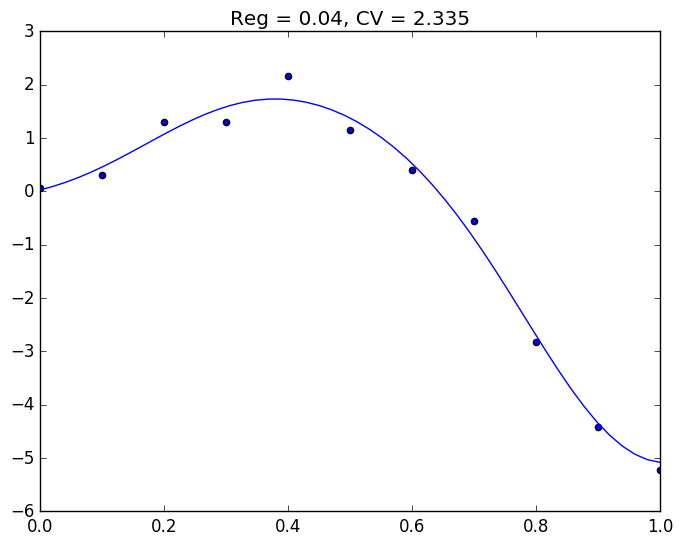

In [29]:
X = linspace(0,1,11)'
Y = 5 * X .* sin(5 .* X) .+ 0.3 * randn(11)'
basisFunction = r->exp(-10*r^2)
cvMetric(train) = cv(X, Y, train, cvSetJackKnife(size(X,2)), sqloss)
fig = figure()
@manipulate for regularizationParameter = 0:0.02:0.1
    withfig(fig) do
        scatter(X,Y)
        mytrain(x,y) = radialBasisInterpolation(x, y, basisFunction, regularizationParameter)
        f = mytrain(X,Y)
        plot(f)
        title(@sprintf("Reg = %.2f, CV = %.3f", regularizationParameter, cvMetric(mytrain)))
    end
end